# SETUP

In [19]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer, compute_per_channel_dice
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet
import torch
from astropy.io import fits
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel
from scipy import ndimage as ndi
import skimage.measure as skmeas
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap


Properties of pre-trained model

In [4]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=2
inChannels=1
terminal_show_freq=50
model='VNET'
opt='adam'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}
k = 1
model_name = model
date_str = ""
save = ('../saved_models/fold_' + str(k) + '_checkpoints/' + model_name + '_', dataset_name + "_" + date_str)[0]

Load pre-trained model

In [5]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=2
        self.cuda = False
        self.pretrained = pretrained
        self.dataset_name = 'hi_source'
        self.save = './inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
args = argsclass('VNET', 'adam', 1e-2, 1, 2, "../saved_models/fold_4_checkpoints/VNET_/VNET__BEST.pth")
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45603934


1

In [12]:
train_df = pd.read_csv("../saved_models/fold_%s_checkpoints/VNET_/train.csv"%k, header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models/fold_%s_checkpoints/VNET_/val.csv"%k, header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])

In [13]:
val_df["loss"] = val_df.loss.str.split(":", expand=True)[1]
train_df["loss"] = train_df.loss.str.split(":", expand=True)[1]
val_df["dsc"] = val_df.dsc.str.split(":", expand=True)[1]
train_df["dsc"] = train_df.dsc.str.split(":", expand=True)[1]
train_df = train_df[['epoch', 'loss', 'dsc']]
val_df = val_df[['epoch', 'loss', 'dsc']]

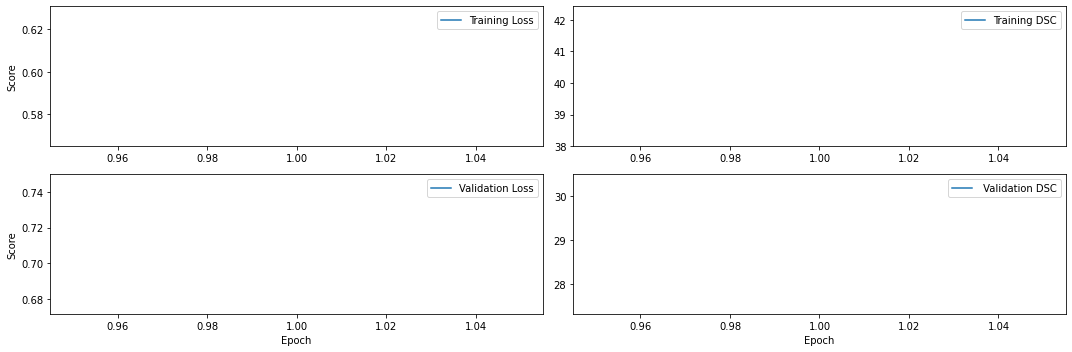

In [14]:
fig, axes = plt.subplots(2, 2, figsize = (15, 5))

axes[0][0].plot(train_df.epoch, train_df.loss.astype(float), label="Training Loss")
axes[0][1].plot(train_df.epoch, train_df.dsc.astype(float), label="Training DSC")
axes[1][0].plot(val_df.epoch, val_df.loss.astype(float), label="Validation Loss")
axes[1][1].plot(val_df.epoch, val_df.dsc.astype(float), label=" Validation DSC")

axes[1][0].set_xlabel("Epoch")
axes[1][1].set_xlabel("Epoch")
axes[0][0].set_ylabel("Score")
axes[1][0].set_ylabel("Score")
axes[0][0].legend()
axes[1][0].legend()
axes[1][1].legend()
axes[0][1].legend()
fig.tight_layout()

Load the test subcubes

In [15]:
def prepare_data(data):
    interval = ZScaleInterval()
    return interval(np.nan_to_num(np.moveaxis(data, 0, 2)))

In [8]:
# model.eval()
# for file in listdir("../data/testing/Input/"):
#     if "noisefree_" in file:
#         print(file)
#         orig_data = fits.getdata("../data/testing/Input/"+file)[:64, :128, :128]
#         prepared_data = prepare_data(orig_data)
#         realseg_data = fits.getdata("../data/testing/Target/mask_"+file.split("_")[-1])[:64, :128, :128]

#         data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
#         with torch.no_grad():
#             out_cube = model.inference(data_loader_tensor)

#         loss_dice, per_ch_score = criterion(out_cube, torch.FloatTensor(np.moveaxis(realseg_data, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...])
#         print(loss_dice)
#         fig, axes = plt.subplots(1, 4, figsize=(10, 10))
#         axes[0].imshow(orig_data[1])
#         axes[1].imshow(prepared_data[..., 1])
#         axes[2].imshow(realseg_data[1])
#         axes[3].imshow(out_cube.squeeze()[..., 1])
#         plt.show()

In [16]:
orig_data = fits.getdata("../data/training/Input/loud_1245mosC.fits")[133:197, 800:800+128, 1500:1500+128]
realseg_data = fits.getdata("../data/training/Target/mask_1245mosC.fits")[133:197, 800:800+128, 1500:1500+128]

In [18]:
model.eval()
prepared_data = prepare_data(orig_data)
mask_tensor = torch.FloatTensor(np.moveaxis(realseg_data, 0, 2).astype(np.float32)).unsqueeze(0)[None, ...]
data_loader_tensor = torch.FloatTensor(prepared_data.astype(np.float32)).unsqueeze(0)[None, ...]
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
    out_mask = model.inference(mask_tensor)

In [36]:
def post_process(tensor):
    out_np = tensor.squeeze()[0].numpy()
    smoothed_gal = ndi.gaussian_filter(out_np, sigma=2)
    t = np.mean(smoothed_gal) + np.std(smoothed_gal)
    new_mask = (smoothed_gal > t)
    object_labels = skmeas.label(new_mask)
    return object_labels

In [40]:
object_labels = post_process(out_cube)
object_labels_mask = post_process(out_mask)
y_true = np.moveaxis(realseg_data, 0, 2)
mask_labels = skmeas.label(np.moveaxis(realseg_data.astype(bool), 0, 2))

intersection = np.sum(np.logical_and(mask_labels, new_mask).astype(int))
union = np.sum(y_true) + np.sum(new_mask)
dice_loss = (2*intersection)/(union)
dice_loss

0.4712302453505632

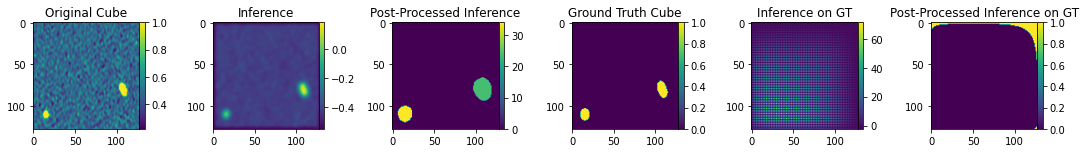

In [41]:
fig, axes = plt.subplots(1, 6, figsize = (15, 5))
im0 = axes[0].imshow(prepared_data[..., 34])
cax0 = make_axes_locatable(axes[0]).append_axes("right", size="5%",pad=0)
fig.colorbar(im0, cax=cax0)
axes[0].set_title("Original Cube")

im1 = axes[1].imshow(out_cube.squeeze()[0][..., 34])
cax1 = make_axes_locatable(axes[1]).append_axes("right", size="5%",pad=0)
fig.colorbar(im1, cax=cax1)
axes[1].set_title("Inference")

im2 = axes[2].imshow(object_labels[..., 34])
cax2 = make_axes_locatable(axes[2]).append_axes("right", size="5%",pad=0)
fig.colorbar(im2, cax=cax2)
axes[2].set_title("Post-Processed Inference")

im3 = axes[3].imshow(realseg_data[34])
cax3 = make_axes_locatable(axes[3]).append_axes("right", size="5%",pad=0)
fig.colorbar(im3, cax=cax3)
axes[3].set_title("Ground Truth Cube")

im4 = axes[4].imshow(out_mask.squeeze()[0][..., 34])
cax4 = make_axes_locatable(axes[4]).append_axes("right", size="5%",pad=0)
fig.colorbar(im4, cax=cax4)
axes[4].set_title("Inference on GT")

im5 = axes[5].imshow(object_labels_mask[..., 34])
cax5 = make_axes_locatable(axes[5]).append_axes("right", size="5%",pad=0)
fig.colorbar(im5, cax=cax5)
axes[5].set_title("Post-Processed Inference on GT")

fig.tight_layout()